#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/precio-portatiles-the-bridge/overview

## Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from Funciones import *

## Data

- Variable a predecir: Price_euros

- Variables predictoras: por defenir

- Variables a desechar: laptop_ID, 

In [2]:
df_test = pd.read_csv('../data/test.csv', index_col=0)
# df_test

In [3]:
df_train = pd.read_csv('../data/train.csv', index_col=0)
# df_train

In [4]:
sample = pd.read_csv('../data/sample_submission.csv')
# sample

## Data exploration

In [5]:
# df_train['TypeName'].nunique()

In [6]:
# df_train['TypeName'].value_counts()

In [7]:
# df_train['OpSys'].value_counts()

## Data processing

## Test

In [8]:
# Para este primer modelo voy a limpiar algunas columnas y cambiar su dtype

#Primero ram
df_test['Ram'] = df_test['Ram'].str.replace('GB', '').astype(int)

# Ahora voy a transformar Weight
df_test['Weight'] = df_test['Weight'].str.replace('kg', '').astype(float)

# Voy a renombar  Weight y le pondré Weigh/kg para que sea más descriptiva y se entienda que los valores numericos hacen referencia a su peso en kg

df_test = df_test.rename(columns={'Weight': 'Weight/kg'})

In [9]:
# Me haré un segundo DF donde desecho las primeras dos columnas porque no las necesito para la predicción

df2_test = df_test.drop(['laptop_ID'], axis=1)

# Voy a ver si puedo sacarle provecho al typeName
# df2_t = df2_t.drop(['TypeName'], axis=1)

In [10]:
# Función que agrupa OS
def group_os(name):
    if 'Windows' in name:
        return 'Windows'
    elif re.search(r'mac', name, re.IGNORECASE):
        return 'Mac'
    elif name in ['Linux', 'Chrome OS', 'Android']:
        return 'Other OS'
    else:
        return 'No OS/Other'

In [11]:
# Extraigo los pixeles
def extraer_pixeles(resolucion):
    # Busca dos números separados por 'x' o 'X'
    match = re.search(r'(\d+)x(\d+)', resolucion, re.IGNORECASE)
    if match:
        ancho, alto = map(int, match.groups())
        return ancho * alto
    else:
        return None  # O un valor por defecto, como 0 o -1


In [12]:
# Función extrae los screen featuring
def screen_featuring(row):
    ips = 'IPS' in row
    touchscreen = 'Touchscreen' in row
    return pd.Series([ips, touchscreen])

In [13]:
def extraer_gb(memoria):
    total_gb = 0

    # Buscar GB
    matches_gb = re.findall(r'(\d+)GB', memoria)
    for match in matches_gb:
        total_gb += int(match)

    # Buscar TB y convertir a GB (1 TB = 1024 GB)
    matches_tb = re.findall(r'(\d+)TB', memoria)
    for match in matches_tb:
        total_gb += int(match) * 1024

    return total_gb if total_gb > 0 else 0  # Devuelve 0 si no se encuentra nada


In [14]:
def codificar_tipo_memoria(memoria):
    if 'SSD' in memoria:
        return 1
    elif 'HDD' in memoria:
        return 2
    elif 'Hybrid' in memoria:
        return 3
    elif 'Flash' in memoria:
        return 4
    else:
        return 0  # O algún otro código para tipos no listados

In [15]:
#  Agrupar por marcas
def asignar_marca_gpu(gpu):
    if 'Intel' in gpu:
        return 'Intel'
    elif 'Nvidia' in gpu:
        return 'Nvidia'
    elif 'AMD' in gpu:
        return 'AMD'
    else:
        return 'Otro'

In [16]:
def clasificar_cpu(cpu):
    if 'i7' in cpu or 'i9' in cpu or 'Ryzen 7' in cpu or 'Ryzen 9' in cpu:
        return 'Alta'
    elif 'i5' in cpu or 'Ryzen 5' in cpu:
        return 'Media'
    else:
        return 'Baja'

In [17]:
def extraer_ghz(cpu):
    match = re.search(r'(\d+\.?\d*)GHz', cpu)
    return float(match.group(1)) if match else 0

In [18]:
# Agrupo varias variables
df2_test['OpSys_Grouped'] = df2_test['OpSys'].apply(group_os)
df2_test['Company_Grouped'] = df2_test['Company'].apply(agrupar_marcas)

# Extraer los píxeles
df2_test['Pixeles_Total'] = df2_test['ScreenResolution'].apply(extraer_pixeles)

# Extraer características de la pantalla
df2_test[['IPS', 'Touchscreen']] = df2_test['ScreenResolution'].apply(screen_featuring)

# Memoria
df2_test['Total_Memory_GB'] = df2_test['Memory'].apply(extraer_gb)
df2_test['Memory_Type_Code'] = df2_test['Memory'].apply(codificar_tipo_memoria)

# Aplico la función asignar brand a GPU
df2_test['GPU_Marca'] = df2_test['Gpu'].apply(asignar_marca_gpu)

# Clasificamos los CPU
df2_test['CPU_Gama'] = df2_test['Cpu'].apply(clasificar_cpu)

# Aplicar la función para extraer la velocidad de GHz
df2_test['CPU_GHz'] = df2_test['Cpu'].apply(extraer_ghz)

In [27]:
df2_test

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,...,OpSys_Grouped,Company_Grouped,Pixeles_Total,IPS,Touchscreen,Total_Memory_GB,Memory_Type_Code,GPU_Marca,CPU_Gama,CPU_GHz
id,,,,,,,,,,,,,,,,,,,,,
181,HP,Spectre x360,Ultrabook,13.3,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7500U 2.7GHz,16,512GB SSD,Intel HD Graphics 620,Windows 10,...,Windows,HP,8294400,True,False,512,1,Intel,Alta,2.7
708,Acer,Aspire 5,Notebook,15.6,1366x768,AMD A12-Series 9720P 2.7GHz,8,256GB SSD,AMD Radeon RX 540,Windows 10,...,Windows,Acer,1049088,False,False,256,1,AMD,Baja,2.7
862,Acer,Aspire ES1-572,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4,500GB HDD,Intel HD Graphics 520,Linux,...,Other OS,Acer,1049088,False,False,500,2,Intel,Baja,2.0
1064,HP,EliteBook 1040,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,...,Windows,HP,2073600,False,False,256,1,Intel,Media,2.3
702,HP,ENVY -,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,Windows 10,...,Windows,HP,2073600,True,False,256,1,Intel,Media,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,Lenovo,Legion Y520-15IKBN,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8,256GB SSD,Nvidia GeForce GTX 1050M,No OS,...,No OS/Other,Lenovo,2073600,True,False,256,1,Nvidia,Alta,2.8
524,Lenovo,IdeaPad Y700-15ISK,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16,512GB SSD,Nvidia GeForce GTX 960,Windows 10,...,Windows,Lenovo,2073600,True,False,512,1,Nvidia,Alta,2.6
1015,HP,250 G5,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4,500GB HDD,Intel HD Graphics 620,No OS,...,No OS/Other,HP,1049088,False,False,500,2,Intel,Media,2.5


In [20]:
# # Detallo de mejor forma los valores unicos que tengo en gpu
# valores_unicos_gpu = df_train['Gpu'].unique()
# for i, gpu in enumerate(valores_unicos_gpu):
#     print(f"{i + 1}. {gpu}")


In [21]:
# def codificar_gpu(gpu):
#     if 'Intel' in gpu:
#         return 1  # Intel (Integradas)
#     elif 'Nvidia' in gpu:
#         return 2  # Nvidia (Dedicadas)
#     elif 'AMD' in gpu:
#         return 3  # AMD (Dedicadas)
#     else:
#         return 4  # Otros

# df2_t['COD_GPU'] = df2_t['Gpu'].apply(codificar_gpu)


In [22]:
# Aplicar One-Hot Encoding a la variable TypeName, al ser tan pocos no hizo falta agruparlos primero
df_encoded_test = pd.get_dummies(df2_test, columns=['TypeName'])

# Creo dummies para CPU_Gama

cpu_gama_dummies = pd.get_dummies(df2_test['CPU_Gama'], prefix='CPU')

# Creo dummies para GPU_Marca
marca_gpu_dummies = pd.get_dummies(df2_test['GPU_Marca'], prefix='GPU')

# Uno GPU_dummies con encoded
df_encoded_test_2 = pd.concat([df_encoded_test, marca_gpu_dummies], axis=1)

# Uno CPU_dummies con Encoded
df_encoded_test_3 = pd.concat([df_encoded_test_2, cpu_gama_dummies], axis=1)


In [23]:
df_encoded_test_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 181 to 1036
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Company                      391 non-null    object 
 1   Product                      391 non-null    object 
 2   Inches                       391 non-null    float64
 3   ScreenResolution             391 non-null    object 
 4   Cpu                          391 non-null    object 
 5   Ram                          391 non-null    int32  
 6   Memory                       391 non-null    object 
 7   Gpu                          391 non-null    object 
 8   OpSys                        391 non-null    object 
 9   Weight/kg                    391 non-null    float64
 10  OpSys_Grouped                391 non-null    object 
 11  Company_Grouped              391 non-null    object 
 12  Pixeles_Total                391 non-null    int64  
 13  IPS                   

In [34]:
df_encoded_test_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 181 to 1036
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Company                      391 non-null    object 
 1   Product                      391 non-null    object 
 2   Inches                       391 non-null    float64
 3   ScreenResolution             391 non-null    object 
 4   Cpu                          391 non-null    object 
 5   Ram                          391 non-null    int32  
 6   Memory                       391 non-null    object 
 7   Gpu                          391 non-null    object 
 8   OpSys                        391 non-null    object 
 9   Weight/kg                    391 non-null    float64
 10  OpSys_Grouped                391 non-null    object 
 11  Company_Grouped              391 non-null    object 
 12  Pixeles_Total                391 non-null    int64  
 13  IPS                   

In [38]:
# # # Eliminar las columnas especificadas
# # df_encoded_test_3.drop(['Company', 'Product', 'Cpu', 'Memory', 'Gpu', 'OpSys'], axis=1, inplace=True)
# # Eliminar las columnas especificadas
# df_encoded_test_3.drop(['OpSys_Grouped', 'Company_Grouped'], axis=1, inplace=True)
# df_encoded_test_3.drop(['GPU_Marca', 'CPU_Gama', 'ScreenResolution'], axis=1, inplace=True)

In [45]:
df_encoded_test_3

,Inches,Ram,Weight/kg,Pixeles_Total,IPS,Touchscreen,Total_Memory_GB,Memory_Type_Code,CPU_GHz,TypeName_2 in 1 Convertible,...,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,GPU_AMD,GPU_Intel,GPU_Nvidia,GPU_Otro,CPU_Alta,CPU_Baja,CPU_Media
id,,,,,,,,,,,,,,,,,,,,,
181,13.3,16,1.30,8294400,True,False,512,1,2.7,False,...,False,True,False,False,True,False,False,True,False,False
708,15.6,8,2.20,1049088,False,False,256,1,2.7,False,...,True,False,False,True,False,False,False,False,True,False
862,15.6,4,2.40,1049088,False,False,500,2,2.0,False,...,True,False,False,False,True,False,False,False,True,False
1064,14.0,8,1.43,2073600,False,False,256,1,2.3,False,...,True,False,False,False,True,False,False,False,False,True
702,13.3,8,1.34,2073600,True,False,256,1,2.5,False,...,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,15.6,8,2.40,2073600,True,False,256,1,2.8,False,...,False,False,False,False,False,True,False,True,False,False
524,15.6,16,3.31,2073600,True,False,512,1,2.6,False,...,False,False,False,False,False,True,False,True,False,False
1015,15.6,4,1.96,1049088,False,False,500,2,2.5,False,...,True,False,False,False,True,False,False,False,False,True


## Train

In [46]:
# Para este primer modelo voy a limpiar algunas columnas y cambiar su dtype

#Primero ram
df_train['Ram'] = df_train['Ram'].str.replace('GB', '').astype(int)

# Ahora voy a transformar Weight
df_train['Weight'] = df_train['Weight'].str.replace('kg', '').astype(float)

# Voy a renombar  Weight y le pondré Weigh/kg para que sea más descriptiva y se entienda que los valores numericos hacen referencia a su peso en kg

df_train = df_train.rename(columns={'Weight': 'Weight/kg'})

In [47]:
# Me haré un segundo DF donde desecho las primeras dos columnas porque no las necesito para la predicción

df2_train = df_train.drop(['laptop_ID'], axis=1)

# Voy a ver si puedo sacarle provecho al typeName
# df2 = df2.drop(['TypeName'], axis=1)

In [48]:
# Agrupo varias variables
df2_train['OpSys_Grouped'] = df2_train['OpSys'].apply(group_os)
df2_train['Company_Grouped'] = df2_train['Company'].apply(agrupar_marcas)

# Extraigo y creo otras variables
# Extraer los píxeles
df2_train['Pixeles_Total'] = df2_train['ScreenResolution'].apply(extraer_pixeles)

# Extraer características de la pantalla
df2_train[['IPS', 'Touchscreen']] = df2_train['ScreenResolution'].apply(screen_featuring)

# Extraer cantidad y codificar las memorias
df2_train['Total_Memory_GB'] = df2_train['Memory'].apply(extraer_gb)
df2_train['Memory_Type_Code'] = df2_train['Memory'].apply(codificar_tipo_memoria)

# Asigno marca GPU
df2_train['GPU_Marca'] = df2_train['Gpu'].apply(asignar_marca_gpu)

# Clasificamos los CPU
df2_train['CPU_Gama'] = df2_train['Cpu'].apply(clasificar_cpu)

# Aplicar la función para extraer la velocidad de GHz
df2_train['CPU_GHz'] = df2_train['Cpu'].apply(extraer_ghz)

In [52]:
#  Aplicar One-Hot Encoding a la variable TypeName, al ser tan pocos no hizo falta agruparlos primero
df_encoded_train = pd.get_dummies(df2_train, columns=['TypeName'])

df_encoded_train

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight/kg,...,Memory_Type_Code,GPU_Marca,CPU_Gama,CPU_GHz,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
id,,,,,,,,,,,,,,,,,,,,,
268,Dell,Inspiron 5567,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36,...,2,AMD,Alta,2.7,False,False,False,True,False,False
347,Asus,X541NA (N4200/4GB/1TB/W10),15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4,1TB HDD,Intel HD Graphics 505,Windows 10,2.00,...,2,Intel,Baja,1.1,False,False,False,True,False,False
353,Toshiba,Portege Z30-C-1CW,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.20,...,1,Intel,Media,2.3,False,False,False,True,False,False
578,Dell,Alienware 17,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42,...,1,Nvidia,Alta,2.8,False,True,False,False,False,False
42,Dell,Latitude E7270,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.26,...,1,Intel,Media,2.4,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Acer,Chromebook C738T-C2EJ,11.6,IPS Panel Touchscreen 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.25,...,4,Intel,Baja,1.6,True,False,False,False,False,False
716,Toshiba,Portege Z30-C-16H,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.20,...,1,Intel,Media,2.3,False,False,False,True,False,False
517,Acer,Aspire ES1-523,15.6,1366x768,AMD A8-Series 7410 2.2GHz,8,1TB HDD,AMD Radeon R5,Windows 10,2.40,...,2,AMD,Baja,2.2,False,False,False,True,False,False


In [53]:
# Creo dummies para CPU_Gama

cpu_gama_dummies_train = pd.get_dummies(df2_train['CPU_Gama'], prefix='CPU')
cpu_gama_dummies_train

,CPU_Alta,CPU_Baja,CPU_Media
id,,,
268,True,False,False
347,False,True,False
353,False,False,True
578,True,False,False
42,False,False,True
...,...,...,...
89,False,True,False
716,False,False,True
517,False,True,False


In [54]:
# Creo dummies para GPU_Marca
marca_gpu_dummies_train = pd.get_dummies(df2_train['GPU_Marca'], prefix='GPU')
marca_gpu_dummies_train

,GPU_AMD,GPU_Intel,GPU_Nvidia
id,,,
268,True,False,False
347,False,True,False
353,False,True,False
578,False,False,True
42,False,True,False
...,...,...,...
89,False,True,False
716,False,True,False
517,True,False,False


In [55]:
# Uno GPU_dummies con encoded
df_encoded_train_2 = pd.concat([df_encoded_train, marca_gpu_dummies_train], axis=1)
df_encoded_train_2

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight/kg,...,CPU_GHz,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,GPU_AMD,GPU_Intel,GPU_Nvidia
id,,,,,,,,,,,,,,,,,,,,,
268,Dell,Inspiron 5567,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36,...,2.7,False,False,False,True,False,False,True,False,False
347,Asus,X541NA (N4200/4GB/1TB/W10),15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4,1TB HDD,Intel HD Graphics 505,Windows 10,2.00,...,1.1,False,False,False,True,False,False,False,True,False
353,Toshiba,Portege Z30-C-1CW,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.20,...,2.3,False,False,False,True,False,False,False,True,False
578,Dell,Alienware 17,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42,...,2.8,False,True,False,False,False,False,False,False,True
42,Dell,Latitude E7270,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.26,...,2.4,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Acer,Chromebook C738T-C2EJ,11.6,IPS Panel Touchscreen 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.25,...,1.6,True,False,False,False,False,False,False,True,False
716,Toshiba,Portege Z30-C-16H,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.20,...,2.3,False,False,False,True,False,False,False,True,False
517,Acer,Aspire ES1-523,15.6,1366x768,AMD A8-Series 7410 2.2GHz,8,1TB HDD,AMD Radeon R5,Windows 10,2.40,...,2.2,False,False,False,True,False,False,True,False,False


In [57]:
# Uno CPU_dummies con Encoded
df_encoded_train_3 = pd.concat([df_encoded_train_2, cpu_gama_dummies_train], axis=1)
df_encoded_train_3

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight/kg,...,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,GPU_AMD,GPU_Intel,GPU_Nvidia,CPU_Alta,CPU_Baja,CPU_Media
id,,,,,,,,,,,,,,,,,,,,,
268,Dell,Inspiron 5567,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36,...,False,True,False,False,True,False,False,True,False,False
347,Asus,X541NA (N4200/4GB/1TB/W10),15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4,1TB HDD,Intel HD Graphics 505,Windows 10,2.00,...,False,True,False,False,False,True,False,False,True,False
353,Toshiba,Portege Z30-C-1CW,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.20,...,False,True,False,False,False,True,False,False,False,True
578,Dell,Alienware 17,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42,...,False,False,False,False,False,False,True,True,False,False
42,Dell,Latitude E7270,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.26,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Acer,Chromebook C738T-C2EJ,11.6,IPS Panel Touchscreen 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.25,...,False,False,False,False,False,True,False,False,True,False
716,Toshiba,Portege Z30-C-16H,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.20,...,False,True,False,False,False,True,False,False,False,True
517,Acer,Aspire ES1-523,15.6,1366x768,AMD A8-Series 7410 2.2GHz,8,1TB HDD,AMD Radeon R5,Windows 10,2.40,...,False,True,False,False,True,False,False,False,True,False


In [58]:
# Eliminar las columnas especificadas
df_encoded_train_3.drop(['Company', 'Product', 'Cpu', 'Memory', 'Gpu', 'OpSys'], axis=1, inplace=True)
df_encoded_train_3.drop(['OpSys_Grouped', 'Company_Grouped'], axis=1, inplace=True)
df_encoded_train_3.drop(['GPU_Marca', 'CPU_Gama', 'ScreenResolution'], axis=1, inplace=True)

In [59]:
df_encoded_train_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 268 to 1179
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       912 non-null    float64
 1   Ram                          912 non-null    int32  
 2   Weight/kg                    912 non-null    float64
 3   Price_euros                  912 non-null    float64
 4   Pixeles_Total                912 non-null    int64  
 5   IPS                          912 non-null    bool   
 6   Touchscreen                  912 non-null    bool   
 7   Total_Memory_GB              912 non-null    int64  
 8   Memory_Type_Code             912 non-null    int64  
 9   CPU_GHz                      912 non-null    float64
 10  TypeName_2 in 1 Convertible  912 non-null    bool   
 11  TypeName_Gaming              912 non-null    bool   
 12  TypeName_Netbook             912 non-null    bool   
 13  TypeName_Notebook     

In [60]:
df_encoded_test_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 181 to 1036
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       391 non-null    float64
 1   Ram                          391 non-null    int32  
 2   Weight/kg                    391 non-null    float64
 3   Pixeles_Total                391 non-null    int64  
 4   IPS                          391 non-null    bool   
 5   Touchscreen                  391 non-null    bool   
 6   Total_Memory_GB              391 non-null    int64  
 7   Memory_Type_Code             391 non-null    int64  
 8   CPU_GHz                      391 non-null    float64
 9   TypeName_2 in 1 Convertible  391 non-null    bool   
 10  TypeName_Gaming              391 non-null    bool   
 11  TypeName_Netbook             391 non-null    bool   
 12  TypeName_Notebook            391 non-null    bool   
 13  TypeName_Ultrabook    

In [61]:
m_corr = df_encoded_train_3.corr()

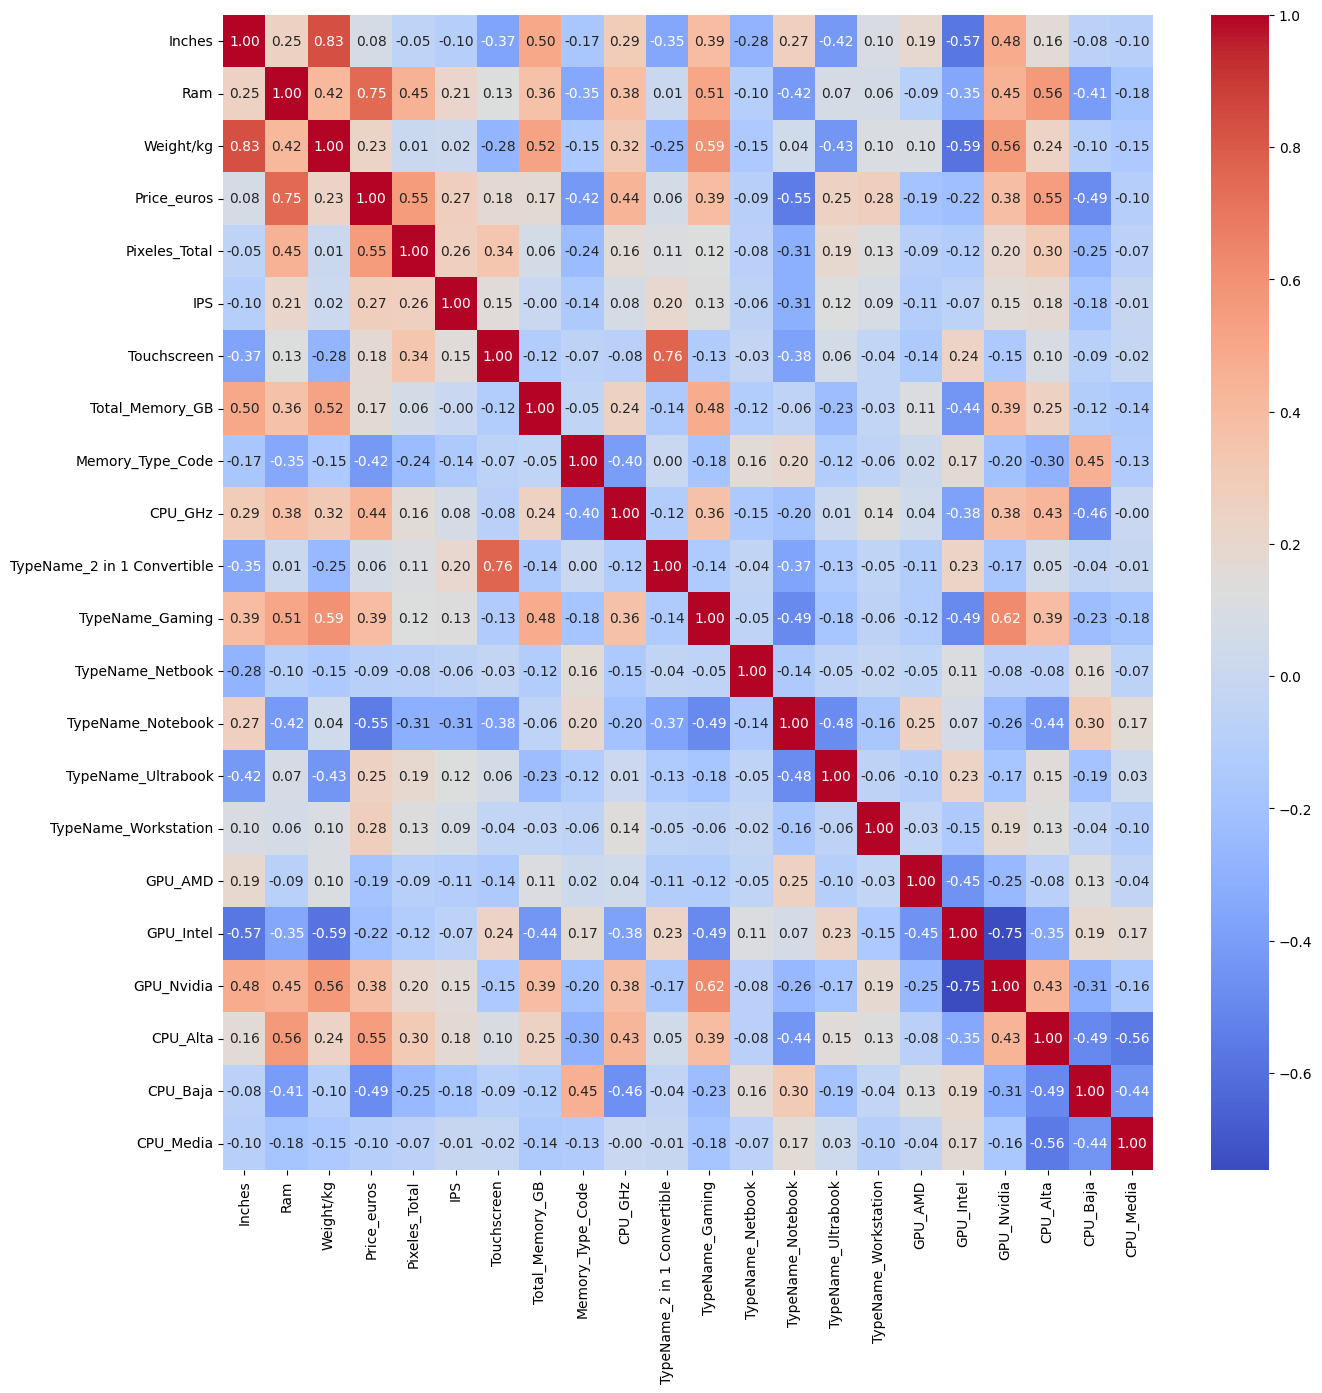

In [62]:
plt.figure(figsize=(15,15))
sns.heatmap(m_corr, annot=True, fmt=".2f", annot_kws={'size': 10}, cmap='coolwarm');

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [ ]:
# X = df_encoded_train.drop(['Price_euros'], axis=1)
# y = df_encoded_train['Price_euros']

### 2. Dividir X_train, X_test, y_train, y_test

In [68]:
X_train = df_encoded_train_3.drop(['Price_euros'], axis=1)
X_test = df_encoded_test_3.drop(['GPU_Otro'], axis=1)
y_train = df_encoded_train_3['Price_euros']
y_test = sample['Price_euros']

In [65]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(912, 21)
(391, 22)
(912,)
(391,)


### 3. Crear y entrenar el modelo


In [66]:
#creating LinearRegression Object
lm = LinearRegression()
#Training the Data Model
lm.fit(X_train, y_train)

LinearRegression()

In [69]:
# Hago mis predicciones
predictions = lm.predict(X_test)

In [ ]:
predictions

In [70]:
from sklearn import metrics

lm.score(X_test, y_test)

-0.8085820507038244

In [71]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))

MAE: 684.7588559333801


In [72]:
from sklearn.metrics import mean_absolute_error

# Ahora voy a escalar a ver si me da mejores resultados

# Ahora voy a escalarlo
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador con los datos de entrenamiento y transformarlos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión lineal
lm_scaled = LinearRegression()
lm_scaled.fit(X_train_scaled, y_train)
# Hacer predicciones con los datos de prueba escalados
predictions_scaled = lm_scaled.predict(X_test_scaled)

# Evaluar el modelo
print('MAE:', mean_absolute_error(y_test, predictions_scaled))

score_scaled = lm_scaled.score(X_test_scaled, y_test)
print("Coeficiente de determinación (R^2) en datos escalados:", round(score_scaled), 2)

MAE: 45330405875088.305
Coeficiente de determinación (R^2) en datos escalados: -1845353925207372140118016 2


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Inicializar el escalador
scaler = StandardScaler()

# Escalar solo las variables numéricas continuas, no las dummies
# Identifica las columnas que necesitas escalar
columnas_para_escalar = [ 'Inches','Ram', 'Weight/kg', 'Pixeles_Total', "Total_Memory_GB"]

# Escalar solo esas columnas
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columnas_para_escalar] = scaler.fit_transform(X_train[columnas_para_escalar])
X_test_scaled[columnas_para_escalar] = scaler.transform(X_test[columnas_para_escalar])

# Entrenar el modelo
lm_scaled = LinearRegression()
lm_scaled.fit(X_train_scaled, y_train)

# Evaluar el modelo
predictions_scaled = lm_scaled.predict(X_test_scaled)
print('MAE:', mean_absolute_error(y_test, predictions_scaled))
score_scaled = lm_scaled.score(X_test_scaled, y_test)
print("Coeficiente de determinación (R^2) en datos escalados:", score_scaled)


In [ ]:
dicccionario ={'id':df_encoded_test.index,"Price_euros": predictions_scaled}

In [ ]:
df_scal = pd.DataFrame(dicccionario)
df_scal

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                df_to_submit.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")


In [ ]:
df_scal.to_csv('quinto_modelo_2.csv', index=False)